The dynamics reproduced with summer here appear qualitatively similar,
but do not match exactly.
Not all model parameters are specified exactly in the textbook,
which is presumably the explanation.
For example, the size of the population, the size of the infectious seed are not stated
and the numerical solving algorithm are not specified.

As noted below, the third panel appears to be showing all deaths of HIV-positive persons,
rather than just the ones attributable to HIV/AIDS.
It is logical that this must be the case,
because at steady state the rate of infection is equal to the rate of death
and there is no other way to exit the HIV compartments.

Note that panel (a) is the same as Figure 9.9 (a).

In [1]:
from jax import numpy as jnp
import matplotlib.pyplot as plt

from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter, DerivedOutput, Function, Time

In [2]:
def build_hiv_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Infectious", 
        "AIDS"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=("Infectious",),
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="Susceptible",
        dest="Infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("infectious_period"),
        source="Infectious", 
        dest="AIDS"
    )
    model.add_universal_death_flows(
        "non_aids_mortality",
        1. / Parameter("expectancy_at_debut"),
    )
    model.add_replacement_birth_flow(
        "recruitment",
        "Susceptible",
    )
    model.add_death_flow(
        "aids_mortality",
        1. / Parameter("aids_period"),
        "AIDS",
    )
    
    # Activity rate stratification
    activity_strata = ("High", "Low")
    activity_strat = Stratification(
        "activity",
        activity_strata,
        compartments,
    )
    high_prop = Parameter("high_prop")
    low_prop = 1. - high_prop
    activity_strat.set_population_split(
        {
            "High": high_prop,
            "Low": low_prop,
        }
    )
    activity_strat.set_flow_adjustments(
        "recruitment",
        adjustments={
            "High": high_prop,
            "Low": low_prop,
        },
    )
    
    # From equation 8.20
    high_prop = Parameter("high_prop")
    high_rate = Parameter("high_partner_change_rate")
    low_rate = Parameter("low_partner_change_rate")
    high_partner_change_prop = high_rate * high_prop / (high_rate * high_prop + low_rate * (1. - high_prop))
    low_partner_change_prop = 1. - high_partner_change_prop
    
    def build_matrix(high_change_prop, low_change_prop):
        mixing_matrix = jnp.array([[high_change_prop, low_change_prop]])  # The "g" values
        mixing_matrix = jnp.repeat(mixing_matrix, 2, axis=0)  # Double up to a square array
        return mixing_matrix
    
    activity_strat.set_flow_adjustments(
        "infection",
        {
            "High": Multiply(Parameter("high_partner_change_rate")),  # Or multiply top row of matrix by this
            "Low": Multiply(Parameter("low_partner_change_rate")),  # Or multiply bottom row of matrix by this
        },
    )
    mixing_matrix = Function(build_matrix, (high_partner_change_prop, low_partner_change_prop))

    activity_strat.set_mixing_matrix(mixing_matrix)
    model.stratify_with(activity_strat)
    
    # Outputs
    model.request_output_for_compartments(
        "infectious",
        ["Infectious"],
        save_results=False,
    )
    model.request_output_for_compartments(
        "total",
        compartments,
        save_results=False,
    )
    model.request_function_output(
        "Prevalence",
        DerivedOutput("infectious") / DerivedOutput("total") * 100.,
    )
    model.request_output_for_flow(
        "HIV infections",
        "infection",
    )
    model.request_function_output(
        "Incidence",
        DerivedOutput("HIV infections") / DerivedOutput("total") * 100.,
    )
    model.request_output_for_flow(
        "mortality",
        "aids_mortality",
    )
    model.request_cumulative_output(
        "Cumulative mortality",
        "mortality",
    )
    model.request_output_for_flow(
        "non_aids_mortality",
        "non_aids_mortality",
    )
    model.request_output_for_compartments(
        "hiv_number",
        ("Infectious", "AIDS",),
    )
   
    # This is actually the total number of deaths of people with HIV, not necessarily from AIDS
    model.request_function_output(
        "Deaths",
        func=DerivedOutput("mortality") + (1. / Parameter("expectancy_at_debut")) * DerivedOutput("hiv_number"),
    )

    for stratum in activity_strata:
        model.request_output_for_compartments(
            f"{stratum}_number",
            compartments,
            strata={"activity": stratum},
        )
        model.request_function_output(
            f"{stratum}_prev",
            func=DerivedOutput(f"{stratum}_number") / DerivedOutput("total"),
        )
    model.request_function_output(
        "mean_partner_change",
        func=DerivedOutput("High_prev") * Parameter("high_partner_change_rate") + DerivedOutput("Low_prev") * Parameter("low_partner_change_rate"),
    )

    return model

In [3]:
model_config = {
    "total_population": 1e4,
    "infectious_seed": 10.,
    "end_time": 100.,
}

parameters = {
    "high_prop": 0.15,
    "high_partner_change_rate": 8.,
    "low_partner_change_rate": 0.2,
    "infectious_period": 9.,
    "expectancy_at_debut": 35.,
    "aids_period": 1.,
    "contact_rate": 0.05,
}

In [4]:
hiv_model = build_hiv_model(model_config)
hiv_model.run(parameters=parameters)
outputs = hiv_model.get_derived_outputs_df()

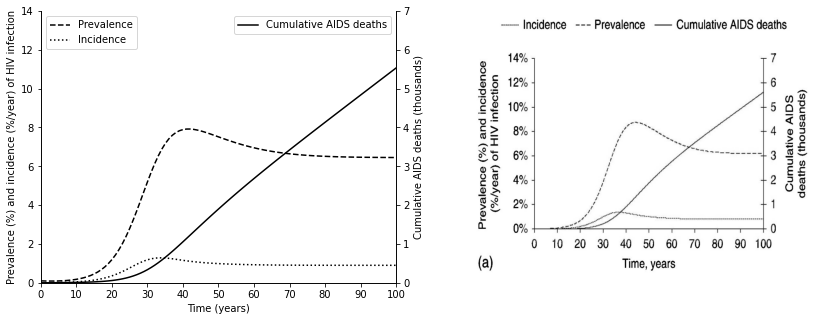

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

for output in ["Prevalence", "Incidence"]:
    left_ax.plot(
        hiv_model.times,
        outputs[output],
        label=output,
        linestyle=":" if output == "Incidence" else "--",
        color="k",
    )
left_ax.set_xlim(0., 100.)
left_ax.set_xticks(range(0, 110, 10))
left_ax.set_xlabel("Time (years)")
left_ax.set_ylim(0., 14.)
left_ax.set_ylabel("Prevalence (%) and incidence (%/year) of HIV infection")
left_ax.legend(loc=2)
left_ax.spines.top.set_visible(False)

twin_ax.plot(
    hiv_model.times,
    outputs["Cumulative mortality"] / 1e3,
    label="Cumulative AIDS deaths",
    color="k",
)
twin_ax.set_ylim(bottom=0.)
twin_ax.set_yticks(range(0, 8))
twin_ax.set_ylabel("Cumulative AIDS deaths (thousands)")
twin_ax.legend(loc=1)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_8_20a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

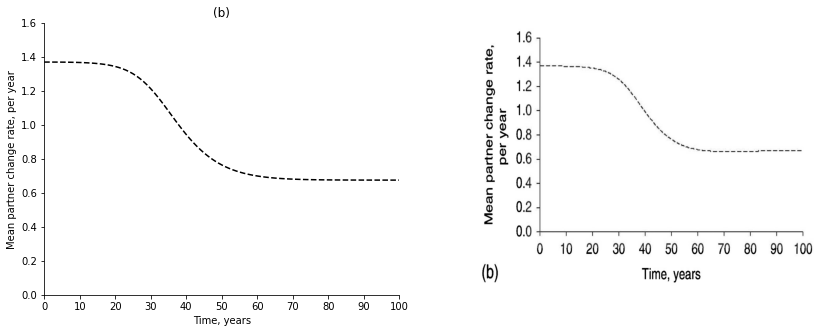

In [6]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    hiv_model.times,
    outputs["mean_partner_change"],
    color="k",
    linestyle="--",
)
left_ax.set_xlim(0., 100.)
left_ax.set_xticks(range(0, 110, 10))
left_ax.set_xlabel("Time, years")
left_ax.set_ylim(0., 1.6)
left_ax.set_ylabel("Mean partner change rate, per year")
left_ax.set_title("(b)")
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_8_20b.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

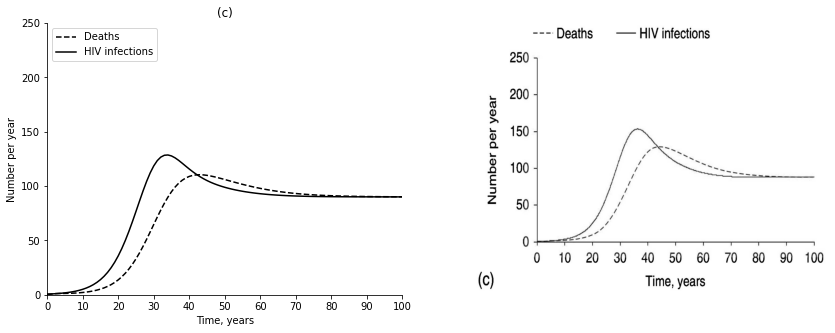

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

for output in ["Deaths", "HIV infections"]:
    left_ax.plot(
        hiv_model.times,
        outputs[output],
        label=output,
        linestyle="--" if output == "Deaths" else "-",
        color="k",
    )
left_ax.set_xlim(0., 100.)
left_ax.set_xticks(range(0, 110, 10))
left_ax.set_xlabel("Time, years")
left_ax.set_ylim(0., 250.)
left_ax.set_ylabel("Number per year")
left_ax.legend(loc=2)
left_ax.set_title("(c)")
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_8_20c.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");